# Pitchfork Analysis
## Part 1: Data cleaning and EDA

Wherein, I load and review some pitchfork data I scraped, and prepare it for specific analysis.

### Setup

Let's take a look at the data.

This was gathered by scraping the Album Reviews site, and so primarily focuses on Album, Artist, Rating, and Review Text. I also gathered the publishing date, and record label, in case there is anything interesting to be done there. I also the page title, and the url I accessed the page on. The data was retrieved in December 2021.

In [1]:
import pandas as pd
from nltk.corpus import stopwords
import numpy as np
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import scipy.stats
from scipy.ndimage.filters import uniform_filter1d
import statsmodels.formula.api as smf
import statsmodels
from statsmodels.graphics import gofplots

pd.options.mode.chained_assignment = None 

df_albums = pd.read_pickle("data/FullAlbums.pkl").T
print(df_albums.shape)
df_albums.head()


(24174, 10)


,album,artist,body,date_published,genre,rating,record_label,title,url,search_base
0,Wallop,[!!!],"[The New York party monsters change course, em...",2019-09-07T05:00:00,[Rock],7.2,Warp,!!!: Wallop Album Review | Pitchfork,https://pitchfork.com/reviews/albums/-wallop/,NaN
1,Challenge Me Foolish,[µ-Ziq],"[Following two previous archival collections, ...",2018-04-16T05:00:00,[Electronic],5.8,Planet Mu,µ-Ziq: Challenge Me Foolish Album Review | Pit...,https://pitchfork.com/reviews/albums/-ziq-chal...,NaN
2,God Level,[03 Greedo],[The Los Angeles rapper’s final album before h...,2018-07-05T05:00:00,[Rap],8.0,Alamo,03 Greedo: God Level Album Review | Pitchfork,https://pitchfork.com/reviews/albums/03-greedo...,NaN
3,Netflix & Deal,"[03 Greedo, Kenny Beats]",[The incarcerated Watts rapper’s latest is a l...,2019-12-05T06:00:00,[Rap],7.5,Alamo,03 Greedo / Kenny Beats: Netflix & Deal Album ...,https://pitchfork.com/reviews/albums/03-greedo...,NaN
4,"Load It Up, Vol. 01","[03 Greedo, Ron-RonTheProducer]","[The latest from the incarcerated L.A. rapper,...",2020-08-27T05:00:00,[Rap],7.5,Alamo,"03 Greedo / Ron-RonTheProducer: Load It Up, Vo...",https://pitchfork.com/reviews/albums/03-greedo...,NaN



For this initial pass, we will only review data where we can observe the 'review' and there is a genre. We will discard these reviews, and do some initial data processing.


In [2]:
ignore = (df_albums.body.str.len() == 0) | (df_albums.genre.str.len() == 0)
ignore |= (df_albums.rating == 'Error') | (df_albums.body == 'Error') 
df = df_albums.loc[~ignore, :]
df.loc[:,'rating'] = df.loc[:, 'rating'].astype(float)

In [3]:
unique_genres = set([genre for list_of_genres in df['genre'].tolist() for genre in list_of_genres])
for genre in unique_genres:
    df.loc[:, genre] = df.loc[:, 'genre'].apply(lambda x: genre in x)

The 'body' of the text was collected as a list of 'paragraphs', according to the website layout. We need to recombine these for text analysis

In [4]:
df.loc[:, 'body'] = df.loc[:,'body'].apply(lambda x: '\n'.join(x))

### EDA

Now lets try out some exploratory data analysis to get a feel for the data, and possibly test some things about Pitchfork. 

###  Ratings and Genres

My first question, arising from my reading of the site, is: do pitchfork authors give preferential treatment to different genres? I notice Pop and Rap often perform worse than more niche genres than Experimental, Jazz, or World music. Is this true?

First, lets see what pitchfork likes to review. It certainly was initially established as a indie-rock blog. Does rock have an outsized share of reviews?

In [5]:
genre_counts = df.loc[:,unique_genres].sum(axis=0).sort_values()
unique_genres = genre_counts.index.tolist()
print(genre_counts)
genre_counts = genre_counts.values

Global            259
Jazz              657
Folk/Country     1007
Metal            1014
Pop/R&B          2180
Experimental     2507
Rap              2517
Electronic       4690
Rock            11172
dtype: int64


Well, looks like it, by a long shot! Let's next look at the distribution of ratings by genre.

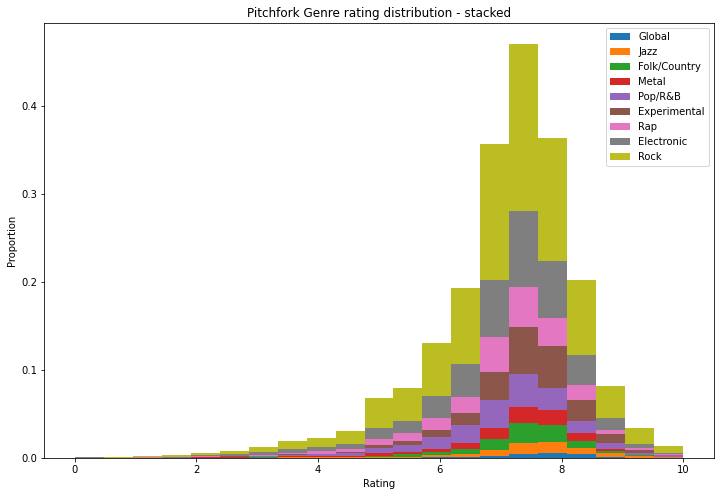

In [6]:
f, axes = plt.subplots(1, 1,figsize=(12, 8))
ratings = [df.loc[df[genre],'rating'].values for genre in unique_genres]
axes.hist(ratings, label=unique_genres, density=True, stacked=True, histtype='bar', bins=np.linspace(0,10,22))
axes.legend()
axes.set_title("Pitchfork Genre rating distribution - stacked")
axes.set_xlabel("Rating")
axes.set_ylabel("Proportion")
pass

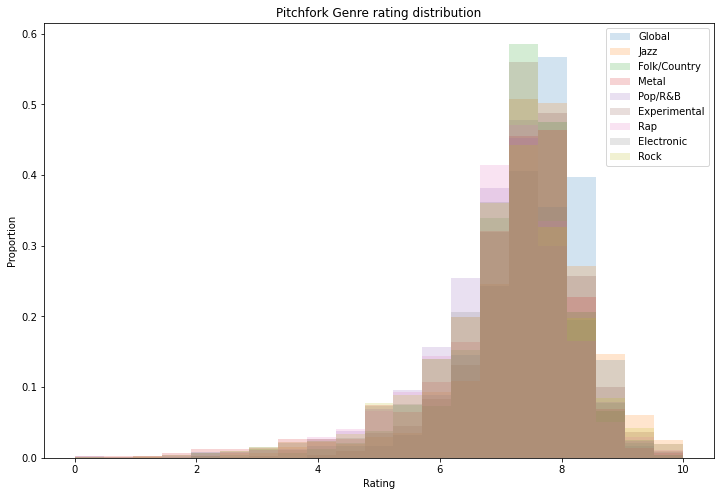

In [7]:
f, axes = plt.subplots(1, 1,figsize=(12, 8))
for i, genre in enumerate(unique_genres):
    axes.hist(df.loc[df[genre],'rating'], label=genre, alpha=.2, density=True, bins=np.linspace(0,10,22))
axes.legend()
axes.set_title("Pitchfork Genre rating distribution")
axes.set_xlabel("Rating")
axes.set_ylabel("Proportion")
pass

It seems surprisingly consistent! Ther edoes seem to be a weighting upwards for Global and Experimental. But there is much more overlap than initially thought. Let's break things out a bit, and see if we can tease things apart. Below I will split out each histogram separately, as well as a mean and the standard deviation. 

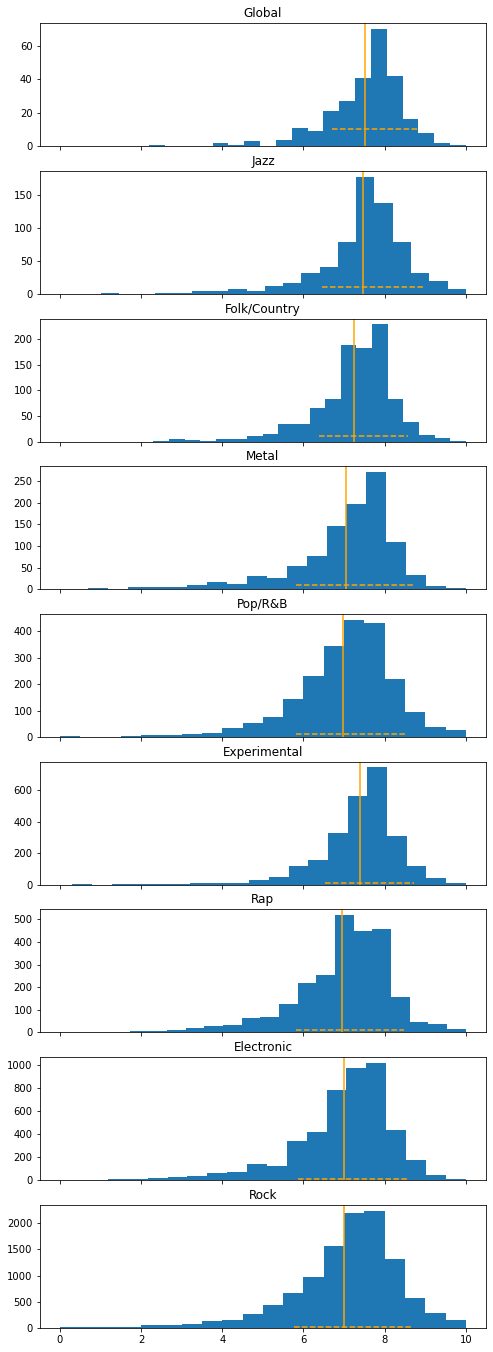

In [8]:
f, axes = plt.subplots(len(unique_genres), 1,figsize=(8, 24),  sharex=True)
for i, genre in enumerate(unique_genres):
    x = df.loc[df[genre],'rating']
    m, sd = x.mean(), x.std()
    axes[i].hist(x, label=genre, bins=20,)
    axes[i].axvline(x=m, c='orange')
    m_norm = m / 10
    sd_norm = sd / 10
    axes[i].axhline(y=10, xmin=m_norm-sd_norm, xmax= m_norm+sd_norm, c='orange', ls='--')
    axes[i].set_title(genre)


We can use an F-test to compare whether our genres are all effectively the same, or not. Specifically, we are testing the hypothesis that the 'average' values of each genre are equal to one another. If our p-value is low, we will reject this hypothesis, and can claim that the genres do not have equal means.

In [9]:
scipy.stats.f_oneway(*ratings)

F_onewayResult(statistic=45.717158554221626, pvalue=1.3554880240118588e-73)

Well, clearly the means do differ statistically significantly. Where does this come from? the F-test does not discriminate if one genre clearly performs better than the rest, but the rest are all equal OR rather they are all quite different from one another. 

Let us do pairwise comparisons then to figure out which genres are significantly differnt from one another. We will also need to do correction for or multiple hypotheses testing, but we can handle that with the bonferonni correction. 


In [10]:
mx = np.zeros((len(unique_genres), len(unique_genres), 2), dtype=float)
for i, genre1 in enumerate(unique_genres):
    for j, genre2 in enumerate(unique_genres):
        if i <= j:
            mx[i,j, 0] = 1
            mx[j,i, 1 ] = 1
            continue
        val = scipy.stats.ttest_ind(ratings[i], ratings[j])
        mx[i,j, 0] = val.statistic
        mx[i,j, 1] = val.pvalue
        
        mx[j,i, 0] = - val.statistic
        mx[j,i, 1] = val.pvalue
# bonferroni correction, the most strict
## alpha
a = .05
n_tests = (len(unique_genres) **2 - len(unique_genres)) / 2 
a_corrected = a / n_tests
different_ix = np.stack(np.where((mx[...,1] < a_corrected) & (mx[...,0] > 0))).T
print(f'among the {n_tests} comparisons, {different_ix.shape[0]}  were different. That\'s {100*different_ix.shape[0]/ n_tests:.2f}%')

among the 36.0 comparisons, 23  were different. That's 63.89%


Clearly quite a bit of variation between the genres. Let's see who comes out on top... 

In [11]:
preferred_genres = np.array(unique_genres)[different_ix]
preferred_genres

array([['Global', 'Folk/Country'],
       ['Global', 'Metal'],
       ['Global', 'Pop/R&B'],
       ['Global', 'Rap'],
       ['Global', 'Electronic'],
       ['Global', 'Rock'],
       ['Jazz', 'Folk/Country'],
       ['Jazz', 'Metal'],
       ['Jazz', 'Pop/R&B'],
       ['Jazz', 'Rap'],
       ['Jazz', 'Electronic'],
       ['Jazz', 'Rock'],
       ['Folk/Country', 'Metal'],
       ['Folk/Country', 'Pop/R&B'],
       ['Folk/Country', 'Rap'],
       ['Folk/Country', 'Electronic'],
       ['Folk/Country', 'Rock'],
       ['Experimental', 'Folk/Country'],
       ['Experimental', 'Metal'],
       ['Experimental', 'Pop/R&B'],
       ['Experimental', 'Rap'],
       ['Experimental', 'Electronic'],
       ['Experimental', 'Rock']], dtype='<U12')

Global, Jazz, and Experimental are all substantially better than the other 6 genres! Folk/Country is rated higher than the remaining five, which are all unable to be distignuished from one another at the bonferroni correct level of comparison (approx. 99.9 % level)

### Over time?

Now, anecdotally, Pitchfork has changed over time. do the genres and ratings bare this out? Let

In [12]:
df['datetime_published'] = df['date_published'].apply(lambda x: datetime.datetime.strptime(x.split('T')[0],'%Y-%m-%d'))

df['date'] = df['datetime_published'].dt.date
df['linear_trend'] = df['date'].apply(lambda x: x.toordinal())
df['linear_trend'] = (df['linear_trend'] - df['linear_trend'].median()) / 365

In [13]:
df['year_quarter'] = (df['datetime_published'].dt.quarter - 1) / 4  + df['datetime_published'].dt.year
agg = {'rating':('mean','std'), 'artist':'count'} 
agg.update({genre : ('sum','mean') for genre in unique_genres})
df_quarters = df.groupby('year_quarter').agg(agg)

df_quarters.loc[:, 'year'] = df_quarters.index.values.astype(int)
df_quarters.loc[:, [(col,'mean') for col in ['rating'] + unique_genres]].round(3)

,rating,Global,Jazz,Folk/Country,Metal,Pop/R&B,Experimental,Rap,Electronic,Rock
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
year_quarter,,,,,,,,,,
1999.00,7.468,0.000,0.045,0.045,0.114,0.045,0.136,0.023,0.341,0.591
1999.25,6.680,0.018,0.127,0.000,0.036,0.036,0.145,0.000,0.473,0.618
1999.50,6.466,0.000,0.000,0.078,0.016,0.109,0.094,0.000,0.203,0.656
1999.75,6.917,0.000,0.000,0.000,0.022,0.000,0.065,0.043,0.304,0.739
2000.00,6.803,0.038,0.013,0.025,0.038,0.038,0.063,0.051,0.190,0.671
...,...,...,...,...,...,...,...,...,...,...
2020.75,7.435,0.000,0.072,0.046,0.046,0.190,0.127,0.169,0.152,0.338
2021.00,7.331,0.008,0.046,0.105,0.021,0.147,0.143,0.181,0.160,0.319


First let us review ratings over time. Has pitchfork ben stable in its ratings over time? or has it changed?

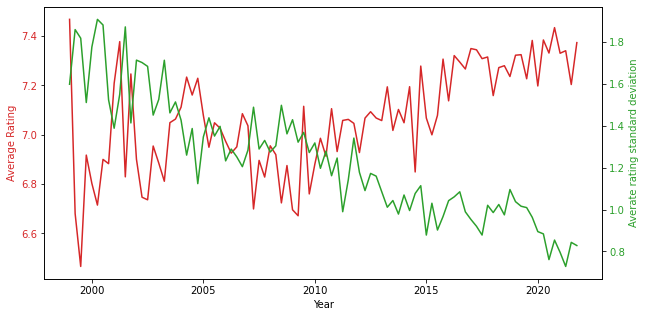

In [14]:
fig, ax1 = plt.subplots(figsize=(10,5)) 
color = 'tab:red'
ax1.set_xlabel('Year') 
ax1.set_ylabel('Average Rating', color = color) 
ax1.plot(df_quarters[('rating','mean')], color = color) 
ax1.tick_params(axis='y', labelcolor = color) 
  
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx() 
  
color = 'tab:green'
ax2.set_ylabel('Averate rating standard deviation', color = color) 
ax2.plot(df_quarters[('rating','std')], color = color) 
ax2.tick_params(axis ='y', labelcolor = color) 




Looks quite clear that we Pitchfork is giving better ratings, and is becoming less volatile in its ratings, it is tending  positive and the variance is going down. Instead of twos and tens, pitchfork is giving out a lot more sevens and eights. Let's clean this up a little bit. 

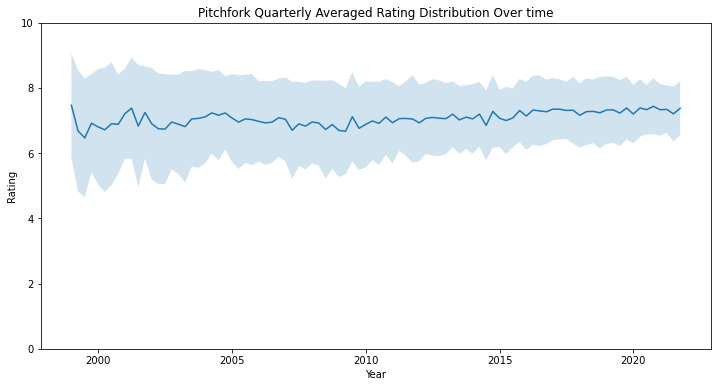

In [15]:
f, ax = plt.subplots(figsize=(12,6))
ax.plot(df_quarters[('rating','mean')])
ax.fill_between(x=df_quarters.index, 
                y1=df_quarters[('rating','mean')] - df_quarters[('rating','std')],
                y2=np.minimum(df_quarters[('rating','mean')] + df_quarters[('rating','std')],10), 
                alpha=.2, )
ax.set_title('Pitchfork Quarterly Averaged Rating Distribution Over time')
ax.set_xlabel('Year')
ax.set_ylabel('Rating')
_ = ax.set_ylim((0,10))

## Genres share over time

Text(0, 0.5, 'Count of reviews')

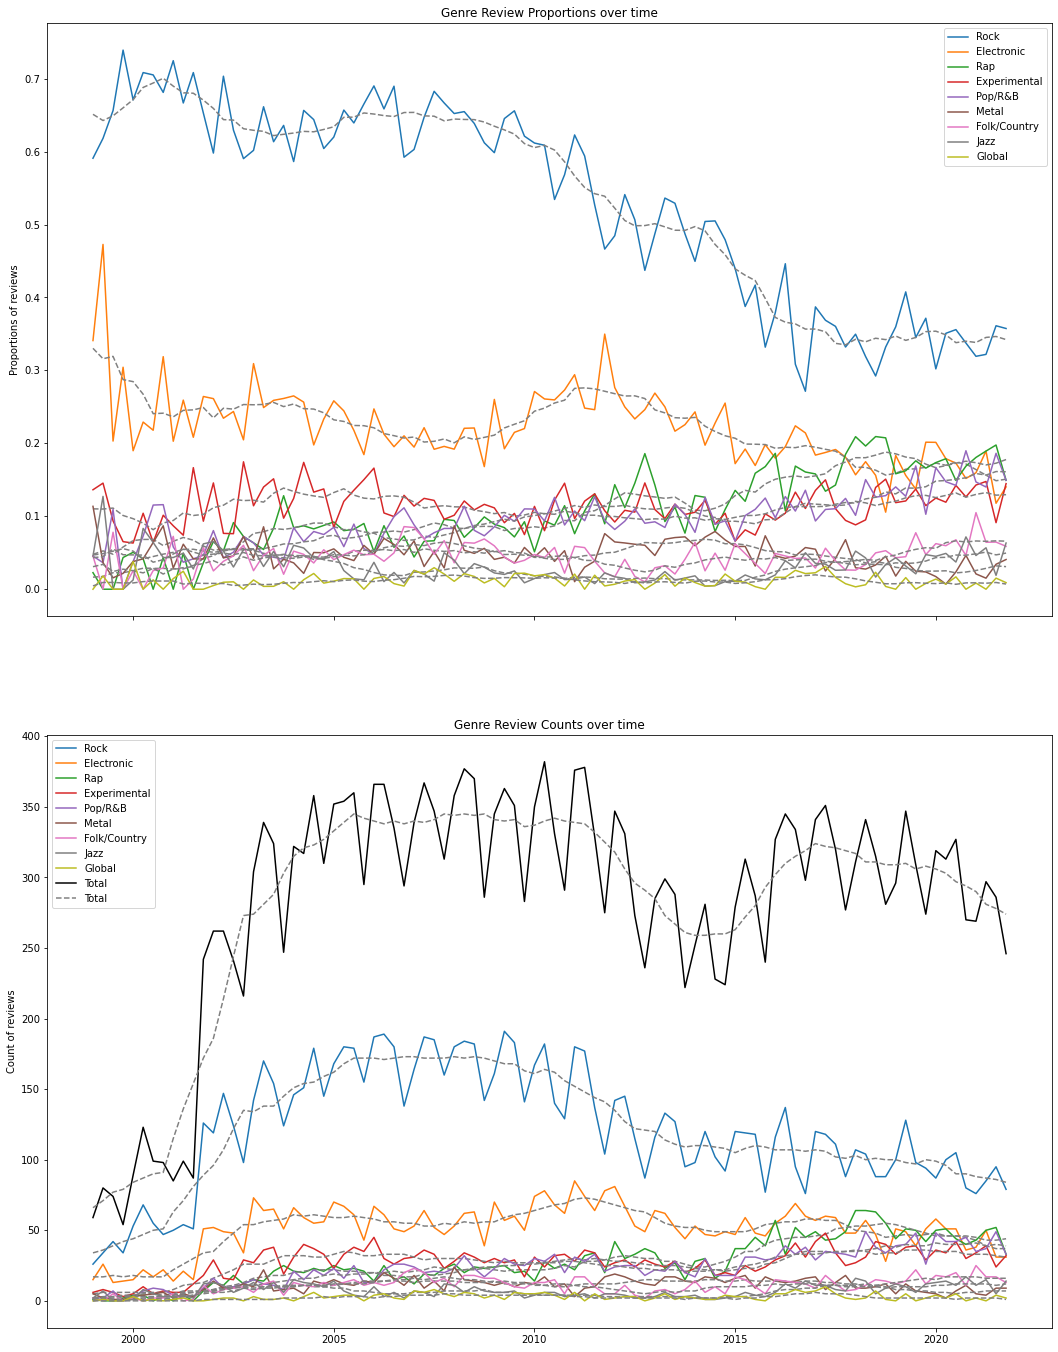

In [16]:
f, ax = plt.subplots(2,1, figsize=(18,24), sharex=True)

for genre in reversed(unique_genres):
    ax[0].plot(df_quarters[(genre,'mean')], label=genre)
    ax[0].plot(df_quarters[(genre,'mean')].index, uniform_filter1d(df_quarters[(genre,'mean')], size=8),c='grey',ls='dashed')
ax[0].legend()
ax[0].set_title('Genre Review Proportions over time')
ax[0].set_ylabel('Proportions of reviews')

for genre in reversed(unique_genres):
    ax[1].plot(df_quarters[(genre,'sum')], label=genre)
    ax[1].plot(df_quarters[(genre,'sum')].index, uniform_filter1d(df_quarters[(genre,'sum')], size=8),c='grey',ls='dashed')

total_reviews_per_period = df_quarters[[(genre,'sum') for genre in unique_genres]].sum(axis=1)
ax[1].plot(total_reviews_per_period, label='Total', c='black')
ax[1].plot(total_reviews_per_period.index, uniform_filter1d(total_reviews_per_period, size=8), label='Total',c='grey',ls='dashed')
ax[1].legend()
ax[1].set_title('Genre Review Counts over time')
ax[1].set_ylabel('Count of reviews')


Clearly the  composition of reviews has changed over time. From a Rock (~65%), Electronic (~25%), and Experimental (~10%) focused blog, with middling attention to any other genre, pitchfork as evolved more into a more general, three tiered blog, of __Rock__ (33%), __Electronic, Rap, Experimental, Pop/R&B__ (10-20%), and __Metal, Folk, Jazz, Global__ (0-5%). 

I wasn't sure if the proportions of genres were going to be misleading without also representing the counts, but it seems like the number of reviews hsa been relatively stable since 2003, excepting for an extended dip between 2011 and 2016. This period of time would be interesting to follow up on!

### Genres and Ratings over time

So, we have seen how pitchfork rates certain genres differently from others (Experimental, Jazz, Global > Folk/Country > Metal, Rock, Pop/R&B, Rap, Electronic). We have seem how pitchfork's ratings change over time (higher ratings, with less variance). We have seen how the share of pitchforks reviews of different genres changes over time. What could be left? Well we could see how pitchfork's ratings of genres changes over time. 

Has pitchfork stayed steady in it's editorial taste? Has it moved from indie rock lovers towards rap obsessives? or from Experimental fetishists towards Global afficianados? Lets see. 

We need calcuate the quarterly average ratings for each genre first. We can't accomplish in the simple groupby so we will need to refer back to the original dataframe. 

In [17]:
for genre in unique_genres:
    for time_ix in df_quarters.index:
        df_quarters.loc[time_ix, (genre,'rating-mean')] = df.loc[(df['year_quarter'] == time_ix) & df[genre], 'rating'].mean()


Let's plot these out. We will plot the ratio of the genre's rating to the average rating, to see how it compares with the rest the review content in that period. We will also add both the baseline (that is, the ratio of the average-ratings to itself, i.e 1.0), as well as the linear trend over the period. 

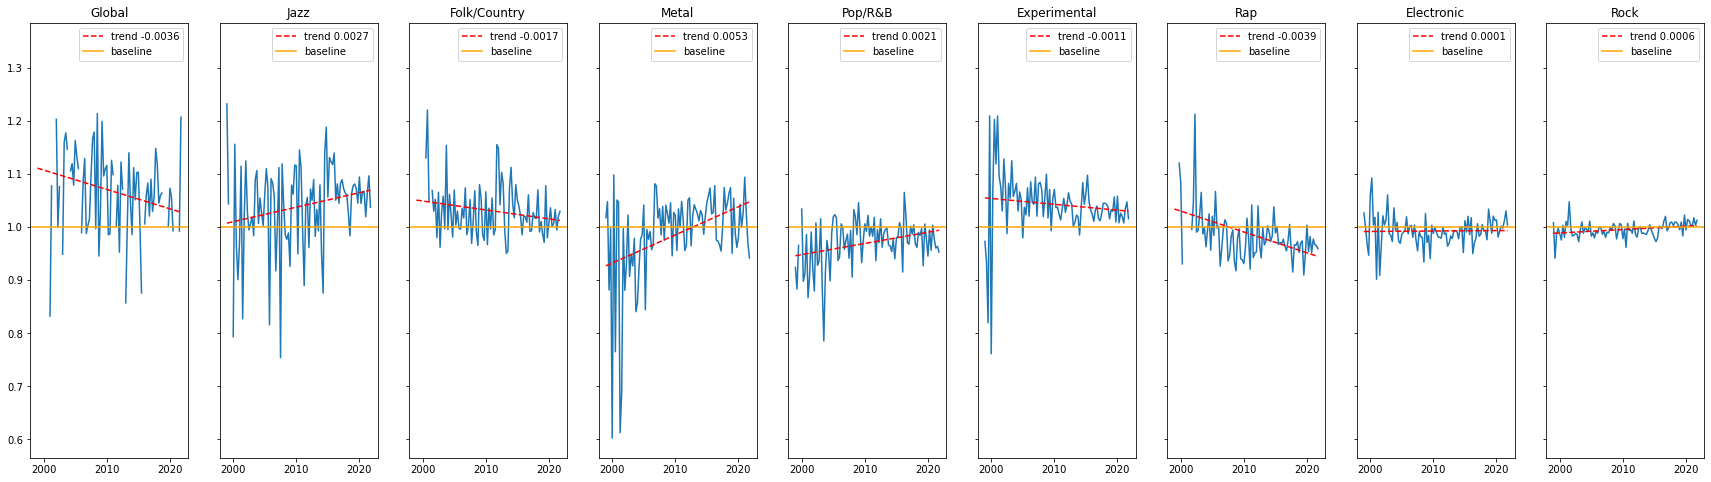

In [18]:
f, ax = plt.subplots(1,len(unique_genres), figsize=(30, 8), sharex=True, sharey=True)
for i, genre in enumerate(unique_genres):
    xy = df_quarters[(genre,'rating-mean')] / df_quarters[('rating','mean')]
    ax[i].plot(xy)
    # fit a trend line
    xy_nn = xy[pd.notnull(xy)]
    p1d = np.polyfit(xy_nn.index,  xy_nn.values, 1,)
    f = np.poly1d(p1d)
    ax[i].plot(xy.index, f(xy.index), c='red', label=f'trend {p1d[0]:.4f}', ls='dashed')
    ax[i].set_title(genre)
    ax[i].axhline(y=1.,c='orange',label='baseline')
    ax[i].legend()

Very interesting!

Though we can't draw obvious conclusions here, it seems to muddy the picture from before. Specifically, the much malinged Metal genre seems to be on the up, with a clear positive slope, while the exalted Global genre is becoming blase. 

### Put it all togehter with a Linear Regression

Lets try and cap the analysis with a stalwart of statistical analysis: a linear regression. Now, we won't be able to any causal analysis here as there are myriad factors external factors influenceing both our features (_genre_ and _time_) and our outcome (_rating_). Perhaps the big bosses at Conde Nast wanted more stable and varied reporting, tending towards both more genre diversity, higher scores, and lower ratings variance. 

We will see if the fruits of our visual exploration corresponds with the linear regression. Presumably they will, but with the interaction of different terms, it is possible that some of our previous analysis were spurious, in the face of complexity. Also, to note: We noticed the variance of `rating` changed over time. We need to correct for this heteroskedasticity, but conveniently, we have the technology (aka [math](https://economics.mit.edu/files/7422)). 


In [19]:
ols_results = smf.ols('rating ~ Electronic + Experimental + Q("Folk/Country") + Global + Jazz + Metal + Q("Pop/R&B") + Rap + Rock + '
                  'linear_trend*Electronic + linear_trend*Experimental + linear_trend*Q("Folk/Country") + linear_trend*Global + '
                  'linear_trend*Jazz + linear_trend*Metal + linear_trend*Q("Pop/R&B") + linear_trend*Rap + linear_trend*Rock', 
                  data=df).fit(cov_type='HC3')

print(ols_results.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     54.24
Date:                Sun, 23 Jan 2022   Prob (F-statistic):          1.50e-201
Time:                        10:26:40   Log-Likelihood:                -34872.
No. Observations:               21786   AIC:                         6.978e+04
Df Residuals:                   21766   BIC:                         6.994e+04
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Looks like the majority of our analysis stays true! 

Global, Jazz, Folk/Country and Experimental all have significant positive coefficients, demonstraitng they are assoicated with higher reviews. Electronic, Pop, Rap and Rock all have significant negative coefficients. 

In addition, there is a positive, significant time coefficient. Among the time interactions, we see muddier warters. However, Metal is trending upwards over time, as we expected. Rap and Experimental also appear to trending downwards with time, which we did not see before. 

Unfortunately, we have a strikingly low R^2, so we are clearly missing a lot of the variance in the data. However, we didn't really expect to, we more wanted to evaluate our visual observations and conjectures. If we want to predict a rating, this model will do you very little good. 

That being said, it is still a matter of course to evaulate the residuals of the model, to see if there is any cause for concern with our takeaways. 


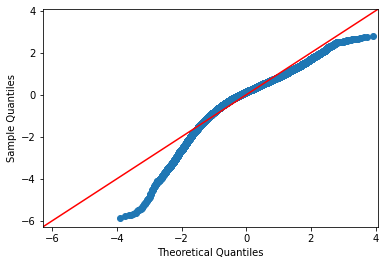

In [20]:
_ = gofplots.qqplot(ols_results.resid, line='45',fit=True)

So, this plot doesn't look great, unfortunately. We would expect the scatterplot to line up with the 45 degree line. There is clearly heavily under the expected quantile line. This sugggests we are predicting closer to the mean. As our features are not highgly variable, it is reasonable that we are very temperate in our predictions. Let's compare the resiudals with the predictions and actual values, to see if this pattern is borne out. 

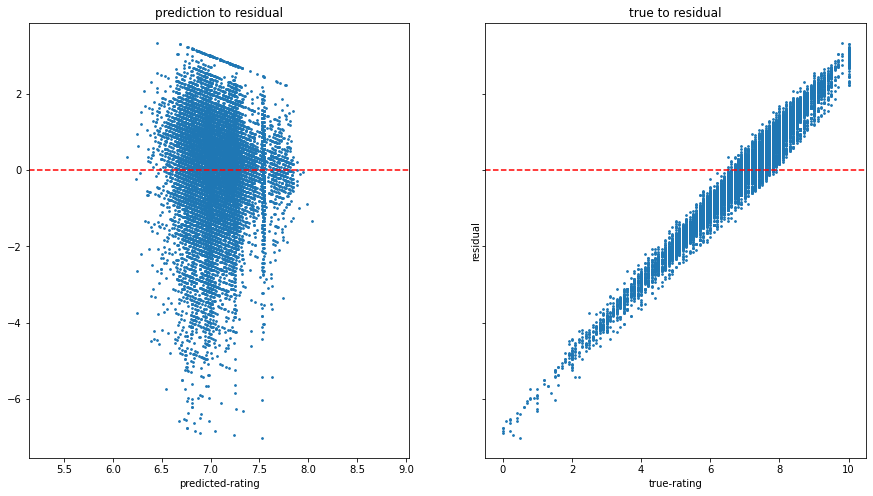

In [21]:
yhat = ols_results.predict(df)
ytrue = df['rating'].values

f, ax = plt.subplots(1,2, figsize=(15,8), sharey=True)
ax[0].scatter(yhat, ols_results.resid, s=3)
ax[0].axline((0,0),(1,0),color='red' ,ls='dashed')
ax[0].set_xlabel('predicted-rating')
ax[0].set_xlim(yhat.min()-1, yhat.max()+1)
ax[0].set_title('prediction to residual')

ax[1].scatter(ytrue, ols_results.resid, s=3)
ax[1].axline((0,0),(1,0),color='red' ,ls='dashed')
ax[1].set_xlabel('true-rating')
ax[1].set_ylabel('residual')
_ = ax[1].set_title('true to residual')



The Prediction-residual plot is affirming, in that the residuals are fairly randomly distirbuted in the prediction range. However, the true-residual plot, we see this 'mean' prediction, where we are are doing quite poorly in the extremes of 0s and 10s. 

### Appendix: Data distribution

Probably more intersting than my indulgent analysis is the data itself, being released! I include a train-test split for ease of cross-analysis comparison

In [22]:
name = 'p4k-20220123'
df[list(unique_genres)] = df[list(unique_genres)].astype(int)
df['body'].iloc[:100].to_csv(f'data/{name}_review-sample.csv', index=False)
df[unique_genres].iloc[:100].astype(int).to_csv(f'data/{name}_genre-sample.csv', index=False)
df['rating'].iloc[:100].to_csv(f'data/{name}_rating-sample.csv', index=False)

In [23]:
df = df.sample(frac=1).reset_index()
df.loc[:df.shape[0]*.85,'test-split'] = 0
df.loc[pd.isnull(df['test-split']),'test-split'] = 1

In [24]:
cols = ['album', 'artist', 'body', 'date_published', 'genre', 'rating','record_label', 'title', 'url', 'search_base', 'Folk/Country', 'Global','Rock', 'Rap', 'Electronic', 'Experimental', 'Jazz', 'Pop/R&B', 'Metal', 'date', 'linear_trend', 'year_quarter','test-split']
df[cols].iloc[:100].to_csv(f'data/{name}-album-reviews-sample.csv')
df[cols].to_csv(f'data/{name}-album-reviews.csv')